In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [2]:
# Load Data and Preprocess
def load_data(filepath):
    df_raw = pd.read_csv(filepath, sep=';')
    df = df_raw.copy()
    # Remove the target column if it exists in the dataset
    if 'x' in df.columns:
        df = df.drop(columns=['x'])

    # Identify numeric and categorical attributes separately

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if categorical_cols:
        df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    else:
        df_encoded = df.copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_encoded.values)
    feature_names = df_encoded.columns.tolist()
    return df_raw, X_scaled, feature_names

#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components, random_state=42)
    x_pca = pca.fit_transform(x)
    return x_pca, pca
#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method)
def find_optimal_clusters(x, max_clusters=10):
    from sklearn.cluster import KMeans
    inertias = []
    K_range = range(1, max_clusters+1)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(x)
        inertias.append(kmeans.inertia_)
    plt.figure(figsize=(8,5))
    plt.plot(list(K_range), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (Sum of squared distances)')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(list(K_range))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    return inertias

# Perform KMeans Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    from sklearn.cluster import KMeans
    if n_clusters is None:
        n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(x)
    return labels, kmeans


#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=None):
    from sklearn.cluster import AgglomerativeClustering
    if n_clusters is None:
        n_clusters = 3
    agg = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    labels = agg.fit_predict(x)
    return labels, agg

#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    from scipy.cluster.hierarchy import linkage
    linked = linkage(x, method='ward')
    return linked

# Plot Dendrogram
def plot_dendrogram(linked, truncate_mode=None, p=30):
    from scipy.cluster.hierarchy import dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linked, truncate_mode=truncate_mode, p=p)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index or (cluster size)')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [3]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, sep=';')# TODO: Load CSV with correct separator

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # TODO: Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']
    X = df[features]
# TODO: Select features

    # TODO: Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # TODO: Apply StandardScaler

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


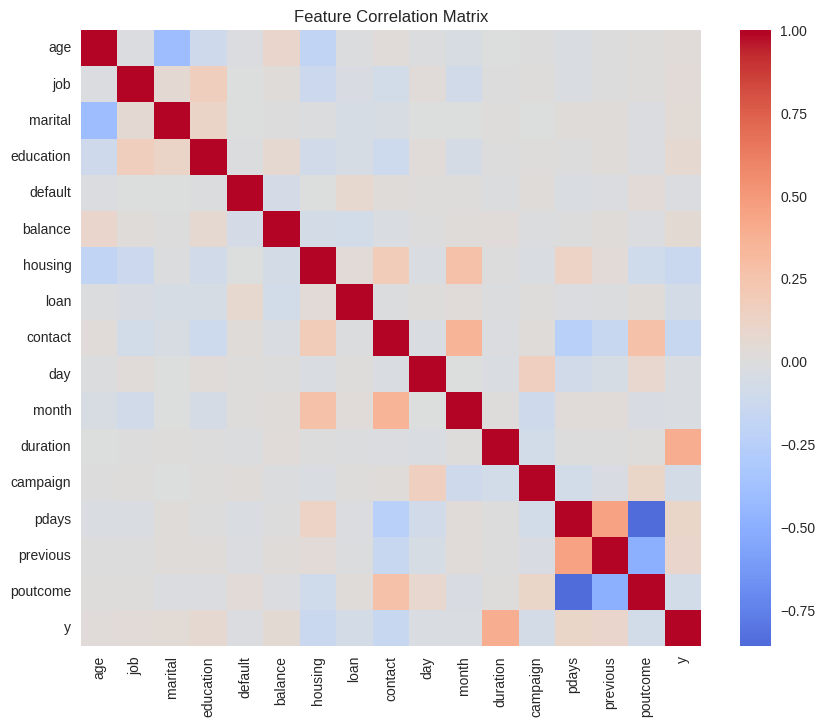

In [4]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        rng = np.random.RandomState(self.random_state)
        n_samples = X.shape[0]
        if self.n_clusters > n_samples:
            raise ValueError("n_clusters cannot be greater than number of samples")
        indices = rng.choice(n_samples, size=self.n_clusters, replace=False)
        centroids = X[indices].astype(float)
        return centroids

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        if self.centroids is None:
            raise ValueError("Centroids are not initialized.")
        # distances shape: (n_samples, n_clusters)
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        TODO (student):
        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        new_centroids = np.zeros((self.n_clusters, n_features), dtype=float)
        for k in range(self.n_clusters):
            members = X[labels == k]
            if members.shape[0] == 0:
                # Reinitialize empty cluster to a random existing point
                idx = rng.randint(0, X.shape[0])
                new_centroids[k] = X[idx]
            else:
                new_centroids[k] = members.mean(axis=0)
        return new_centroids

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        TODO (student):
        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        X = np.asarray(X)
        self.centroids = self._initialize_centroids(X)
        tol = 1e-6
        for i in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)
            shift = np.linalg.norm(self.centroids - new_centroids)
            self.centroids = new_centroids
            self.labels = labels
            if shift <= tol:
                break
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)
plt.figure(figsize=(10,8))
corr = data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()



## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

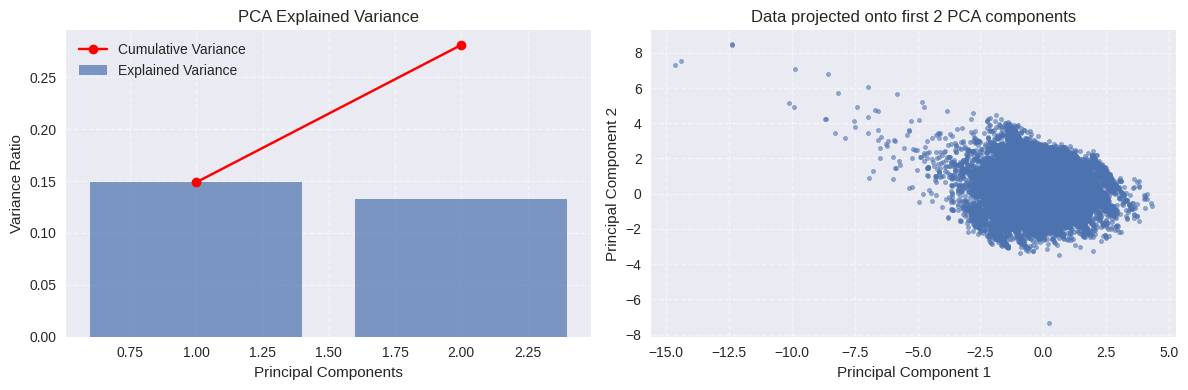

Shape after PCA: (45211, 2)


In [5]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    plt.figure(figsize=(12, 4))

    # Plot explained variance
    # Your code here
    plt.subplot(1, 2, 1)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.7, label='Explained Variance')
    plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', color='red', label='Cumulative Variance')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot data in 2D
    # Your code here
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Data projected onto first 2 PCA components')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

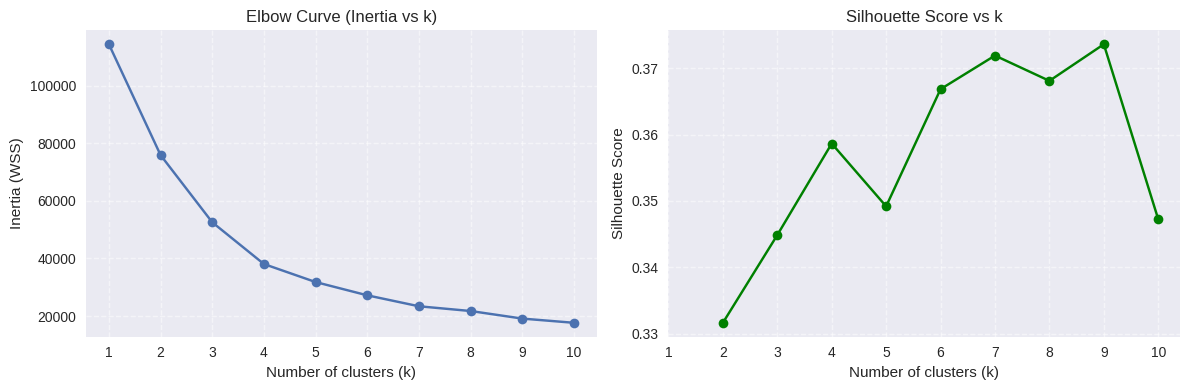

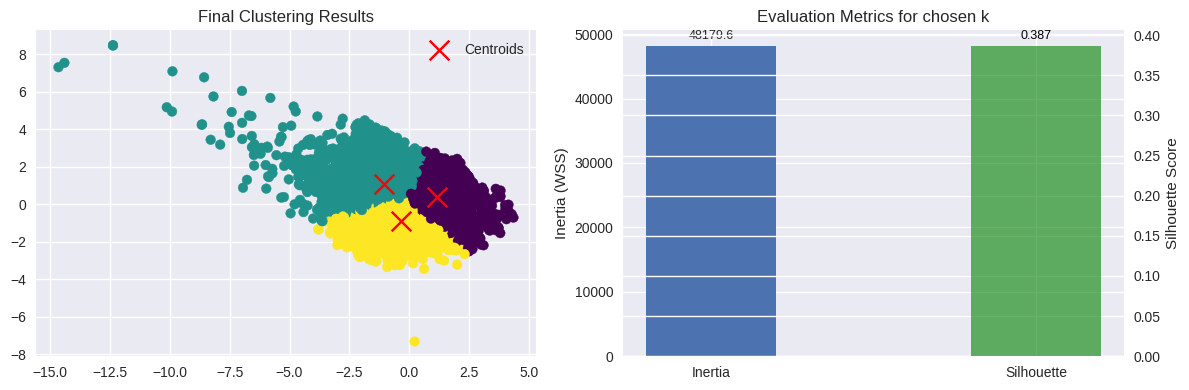

/tmp/ipython-input-4205740399.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sil_df, x='Cluster', y='Silhouette', ax=axes[2], palette='viridis')


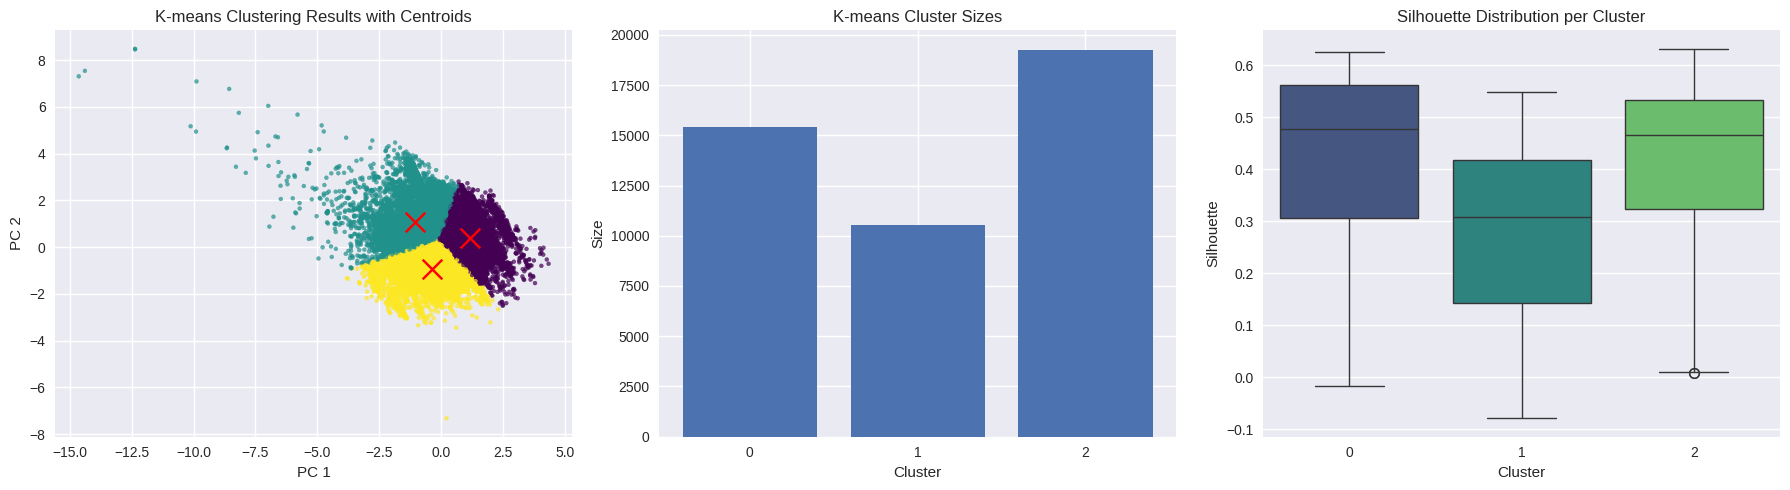


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [6]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia).

    TODO:
    1. For each cluster, calculate the sum of squared distances
       between points and their centroid
    2. Sum up all cluster distances
    """
    # Your code here
    X = np.asarray(X)
    labels = np.asarray(labels)
    centroids = np.asarray(centroids)
    inertia = 0.0
    for k in range(centroids.shape[0]):
        members = X[labels == k]
        if members.shape[0] == 0:
            continue
        diffs = members - centroids[k]
        sq_dists = np.sum(diffs ** 2, axis=1)
        inertia += np.sum(sq_dists)

    # Calculate distances between points and their assigned centroids
    return inertia

def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters.

    TODO:
    1. Try different values of k (1 to max_k)
    2. Calculate inertia for each k
    3. Plot k vs inertia
    4. Help identify the 'elbow' point
    """
    # Your code here
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    inertias = []
    sil_scores = []
    K = range(1, max_k + 1)


    # Calculate inertia for different k values
    # Your code here
    for k in K:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(X)
        centroids = km.cluster_centers_
        inert = calculate_inertia(X, labels, centroids)
        inertias.append(inert)
        # silhouette defined only for k>=2
        if k >= 2:
            sil = silhouette_score(X, labels)
            sil_scores.append(sil)
        else:
            sil_scores.append(np.nan)

    # Create elbow plot
    # Your code here
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(list(K), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (WSS)')
    plt.title('Elbow Curve (Inertia vs k)')
    plt.xticks(list(K))
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.subplot(1,2,2)

    plt.plot(list(K), sil_scores, marker='o', color='green')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs k')
    plt.xticks(list(K))
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
    return inertias

# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)


# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Plot evaluation metrics
plt.subplot(1, 2, 2)
# Your code here: Add relevant evaluation metric plots
chosen_inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
chosen_silhouette = silhouette_score(X_pca, kmeans.labels)
# Plot inertia (left axis)
ax = plt.gca()
bars = ax.bar([0], [chosen_inertia], width=0.4, label='Inertia')
ax.set_ylabel('Inertia (WSS)')
ax.set_xticks([0,1])
ax.set_xticklabels(['Inertia', 'Silhouette'])
# Add a secondary axis for silhouette (scaled to make visualization readable)
ax2 = ax.twinx()
ax2.bar([1], [chosen_silhouette], width=0.4, color='green', alpha=0.6, label='Silhouette')
ax2.set_ylabel('Silhouette Score')
ax.set_title('Evaluation Metrics for chosen k')
# add numeric labels above bars
for rect in bars:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
rect2 = ax2.patches[-1]
ax2.annotate(f'{chosen_silhouette:.3f}', xy=(rect2.get_x() + rect2.get_width() / 2, rect2.get_height()),
             xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Additional figure: K-means final results with 3 plots (scatter with centroids, cluster sizes, silhouette distribution)
from sklearn.metrics import silhouette_samples
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (1) Scatter with centroids (larger, clear view)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis', s=8, alpha=0.7)
axes[0].scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=200)
axes[0].set_title('K-means Clustering Results with Centroids')
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')

# (2) Cluster size bar plot
cluster_sizes = pd.Series(kmeans.labels).value_counts().sort_index()
axes[1].bar(cluster_sizes.index.astype(str), cluster_sizes.values)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Size')
axes[1].set_title('K-means Cluster Sizes')

# (3) Silhouette distribution per cluster (boxplot)
sample_sil = silhouette_samples(X_pca, kmeans.labels)
sil_df = pd.DataFrame({'Cluster': kmeans.labels, 'Silhouette': sample_sil})
sns.boxplot(data=sil_df, x='Cluster', y='Silhouette', ax=axes[2], palette='viridis')
axes[2].set_title('Silhouette Distribution per Cluster')

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")


## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

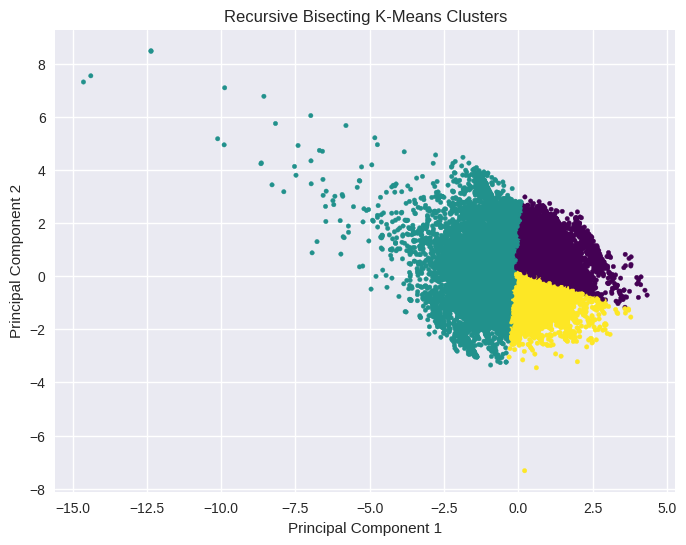

In [7]:
class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)

        Hints:
        - Use sklearn.cluster.KMeans(n_clusters=2, random_state=self.random_state) for the split step
        - Keep a counter for new label ids and increment when creating a new cluster
        - Use boolean indexing to operate on subsets of X efficiently
        """
        from sklearn.cluster import KMeans

        X = np.asarray(X)
        n_samples = X.shape[0]

        # Step 1: Start with all points in one cluster labeled 0
        labels = np.zeros(n_samples, dtype=int)
        next_label_id = 1  # for assigning new clusters
        self.centers_[0] = X.mean(axis=0)

        while len(np.unique(labels)) < self.n_clusters:
            # Step 2: Select the largest cluster to split
            unique_labels, counts = np.unique(labels, return_counts=True)
            cluster_to_split = unique_labels[np.argmax(counts)]
            indices = np.where(labels == cluster_to_split)[0]
            if len(indices) < 2:
                # can't split a single point cluster, stop early
                break

            X_subset = X[indices]

            # Step 3: Apply KMeans (k=2) to this subset
            kmeans = KMeans(n_clusters=2, random_state=self.random_state, n_init='auto')
            sub_labels = kmeans.fit_predict(X_subset)

            # Step 4: Assign new labels
            # Keep the original label for one subcluster, assign a new label for the other
            child0_idx = indices[sub_labels == 0]
            child1_idx = indices[sub_labels == 1]
            if len(child0_idx) >= len(child1_idx):
                keep_idx, new_idx = child0_idx, child1_idx
            else:
                keep_idx, new_idx = child1_idx, child0_idx

            new_label = next_label_id
            next_label_id += 1

            labels[new_idx] = new_label

            # Step 5: Record tree and centroids
            self.split_tree[cluster_to_split] = (cluster_to_split, new_label)
            self.centers_[cluster_to_split] = X[labels == cluster_to_split].mean(axis=0)
            self.centers_[new_label] = X[labels == new_label].mean(axis=0)

            if len(np.unique(labels)) >= self.n_clusters:
                break

        self.labels_ = labels
        return self.labels_


# Example (for instructor use only):
# bisect = BisectingKMeans(n_clusters=4)
# labels = bisect.fit_predict(X_pca)
# plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
bisect = BisectingKMeans(n_clusters=3)
labels_bisect = bisect.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_bisect, cmap='viridis', s=10)
plt.title("Recursive Bisecting K-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!